# Libs y params

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgb
from great_tables import GT, from_column, style, loc
from collections import Counter

# from sklearn import datasets
# Modelado
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay,
    log_loss,
    recall_score,
    brier_score_loss,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from IPython.display import display, Markdown

# Funciones adicionales: 
from functions import (
    plot_distribution,
    plot_calibration_models,
    plot_calibration,
    calibrate_model,
    calibration_table,
    calculate_clf_metrics,
)

import sklearn
sklearn.set_config(transform_output="pandas")

color_verde = "#255255"
color_verde_claro = "#BDCBCC"
TARGET = 'Risk'

In [4]:
import matplotlib
import great_tables
from IPython.display import display, Markdown, Latex
Markdown(f"""
**Procesamiento de datos**:\n
pandas=={pd.__version__}\n
numpy=={np.__version__}\n
\n
**Modelado**:\n
scikit-learn=={sklearn.__version__}\n
\n
**Visualización y tablas:**\n
matplotlib=={matplotlib.__version__}\n
seaborn=={sns.__version__}\n
great_tables=={great_tables.__version__}\n
""")


**Procesamiento de datos**:

pandas==2.2.1

numpy==1.26.4



**Modelado**:

scikit-learn==1.3.0



**Visualización y tablas:**

matplotlib==3.8.0

seaborn==0.12.2

great_tables==0.5.0



# Data

In [5]:
df = (pd.read_csv('https://raw.githubusercontent.com/karbartolome/workshops/main/20240513-uba-calibracion/df_german_credit.csv')
  .drop('Unnamed: 0', axis=1)
  .assign(Risk = lambda x: np.where(x['Risk']=='good',0,1))
)
print(f"N obs: {df.shape[0]}, M vars: {df.shape[1]}")

N obs: 1000, M vars: 10


In [6]:
def map_color(data):
    return (data[TARGET] == 1).map(
        {True: color_verde_claro, False: 'white'}
    )

(GT(df.sample(6, random_state=123)
        .set_index(TARGET)
        .reset_index()
    )
    .fmt_currency(columns="Credit amount")
    .tab_style(
        style=style.fill(color=map_color), locations=loc.body(columns=df.columns.tolist()),
    )
    .tab_style(
        style=style.text(color='red', weight = "bold"), locations=loc.body(TARGET),
    )
    .tab_options(
        column_labels_background_color=color_verde,
        table_font_names="Times New Roman"
    )
)

Risk,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
1,29,male,2,own,little,little,"$6,887.00",36,education
1,21,male,2,rent,little,little,$902.00,12,education
0,29,male,1,own,,moderate,"$2,333.00",24,furniture/equipment
1,20,female,2,rent,little,little,"$2,039.00",18,furniture/equipment
0,35,male,2,own,,moderate,"$2,728.00",15,radio/TV
0,23,male,2,own,,moderate,"$1,444.00",15,radio/TV


In [7]:
(df
  .describe().T
  .style.format(precision=2)
  .background_gradient(subset=['min','25%','50%','75%','max'], axis=1)
  .set_caption('Estadística descriptiva - Variables numéricas')
)

,count,mean,std,min,25%,50%,75%,max
Age,1000.00,35.55,11.38,19.00,27.00,33.00,42.00,75.00
Job,1000.00,1.90,0.65,0.00,2.00,2.00,2.00,3.00
Credit amount,1000.00,3271.26,2822.74,250.00,1365.50,2319.50,3972.25,18424.00
Duration,1000.00,20.90,12.06,4.00,12.00,18.00,24.00,72.00
Risk,1000.00,0.30,0.46,0.00,0.00,0.00,1.00,1.00


In [8]:
(df
  .describe(include='object').T
  .style.format(precision=2)
  .background_gradient(subset=['count','unique','freq'], axis=0)
  .set_caption('Estadística descriptiva - Variables categóricas')
)

,count,unique,top,freq
Sex,1000,2,male,690
Housing,1000,3,own,713
Saving accounts,817,4,little,603
Checking account,606,3,little,274
Purpose,1000,8,car,337


# Particiones

In [9]:
y = df[TARGET]
X = df.drop([TARGET], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, shuffle=True, stratify=y, random_state=42
)

# Lo ideal es utilizar la partición de validación para calibración
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=0.5, shuffle=True, stratify=y_test, random_state=42
)

display(Markdown(f"N observaciones en entrenamiento: {X_train.shape[0]}"))
display(Markdown(f"N observaciones en validación: {X_valid.shape[0]}"))
display(Markdown(f"N observaciones en evaluación: {X_test.shape[0]}"))

N observaciones en entrenamiento: 500

N observaciones en validación: 250

N observaciones en evaluación: 250

# Preprocesamiento

In [10]:
numeric_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline([
    ('ohe',OneHotEncoder(
        drop='if_binary',
        min_frequency=0.05,
        handle_unknown='infrequent_if_exist',
        sparse_output=False)
    )
])

preproc = ColumnTransformer([
    ('num', numeric_transformer,
      make_column_selector(dtype_include=['float','int'])),
    ('cat', categorical_transformer,
      make_column_selector(dtype_include=['object','category']))
], verbose_feature_names_out=False)

preproc.fit_transform(X_train).sample(2).round(2)

,Age,Job,Credit amount,Duration,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_little,Saving accounts_moderate,...,Saving accounts_nan,Checking account_little,Checking account_moderate,Checking account_rich,Checking account_nan,Purpose_business,Purpose_car,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_infrequent_sklearn
949,0.21,0.67,0.24,0.36,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
54,0.68,0.67,0.14,0.57,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Modelo no calibrado

In [11]:
model = HistGradientBoostingClassifier(
    max_depth=4,
    learning_rate=0.1,
    max_iter=1000,
    random_state=42,
)

pipe = Pipeline([
    ('preproc', preproc),
    ('modelo', model)
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16a23b910>),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.05,
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16a238c40>)],
                                   verbose_feature_names_out=False)),
                ('modelo',
                 HistGradientBoostingClassifier(max_depth=4, max_iter=1000,
                                                random_state=42))])

In [12]:
preds = pd.DataFrame({
    'y_true': y_test,
    'y_pred': pipe.predict(X_test),
    'y_pred_prob': pipe.predict_proba(X_test)[:,1],
})
m = calculate_clf_metrics(
    preds['y_true'], preds['y_pred'], preds['y_pred_prob'], 
    name='Hist gradient boosting'
)
m.style.format(precision=2)

,Accuracy,Precision,Recall,F1,ROC AUC,Log Loss,Brier Loss
Hist gradient boosting,0.72,0.53,0.53,0.53,0.74,0.93,0.22


# Calibración de probabilidades

In [13]:
preds['bin'] = pd.qcut(preds['y_pred_prob'], q=5, precision=5, duplicates='drop')
preds['bin'] = pd.IntervalIndex(preds['bin']).map(lambda x: pd.Interval(round(x.left, 2), round(x.right, 2)))
preds.sample(3, random_state=123).round(4)

,y_true,y_pred,y_pred_prob,bin
568,0,0,0.1315,"(0.02, 0.23]"
529,0,0,0.0000,"(-0.0, 0.0]"
443,1,1,0.6428,"(0.23, 0.84]"


In [14]:
(preds.groupby('bin')
    .agg(
        N = ('y_true','count'), 
        frac_positive=('y_true','mean'),
        avg_pred = ('y_pred','mean')
    ).round(2).reset_index()
)

,bin,N,frac_positive,avg_pred
0,"(-0.0, 0.0]",50,0.08,0.00
1,"(0.0, 0.02]",50,0.14,0.00
2,"(0.02, 0.23]",50,0.28,0.00
3,"(0.23, 0.84]",50,0.40,0.52
4,"(0.84, 1.0]",50,0.60,1.00


/opt/anaconda3/envs/quarto-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/quarto-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


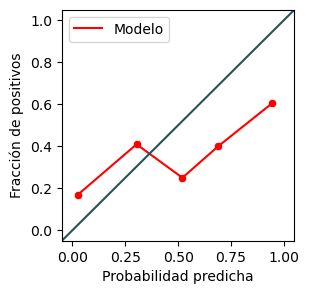

In [15]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(
    y_test, pipe.predict_proba(X_test)[:,1], 
    n_bins=5,
    strategy='uniform'
)
plt.figure(figsize=(3,3))
sns.lineplot(x=prob_pred, y=prob_true, color='red', label='Modelo')
sns.scatterplot(x=prob_pred, y=prob_true, color='red')
plt.axline([0, 0], [1, 1], c=color_verde)
plt.legend()
plt.xlabel("Probabilidad predicha")
plt.ylabel("Fracción de positivos");

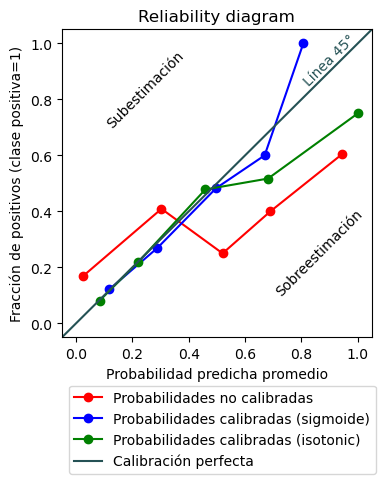

In [21]:
pipe_sigmoid, pipe_isotonic, preds = calibrate_model(
    pipe=pipe,
    X_valid=X_valid, y_valid=y_valid, 
    X_test=X_test, y_test=y_test,
    cal_sigmoid=True,
    cal_isotonic=True,
    model_name='',
    bins=5
)

/opt/anaconda3/envs/quarto-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/quarto-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


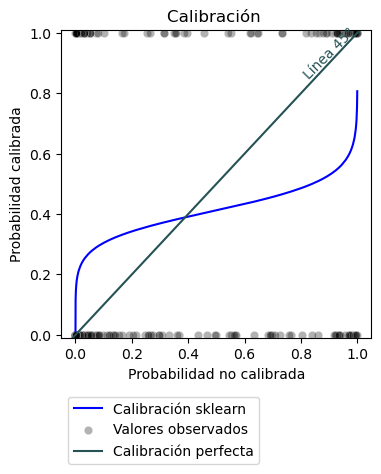

In [25]:
plot_calibration(
    preds=preds,
    y_pred_prob_calibrated='pred_sigmoid',
    model_name=''
)

/opt/anaconda3/envs/quarto-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/quarto-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


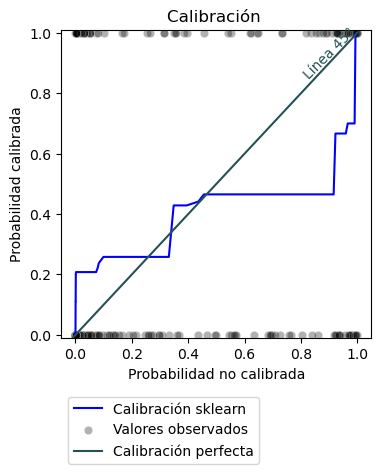

In [26]:
plot_calibration(
    preds=preds,
    y_pred_prob_calibrated='pred_isotonic',
    model_name=''
)

In [17]:
display(Markdown('Modelo no calibrado'))
calibration_table(preds=preds, bins=5, title='Modelo no calibrado')
display(Markdown('Modelo calibrado (sigmoide)'))
calibration_table(preds=preds, pred_column='pred_sigmoid', bins=5, title='Modelo calibrado (sigmoide)')

Modelo no calibrado

/Users/karinabartolome/Documents/GitHub/workshops/20240513-uba-calibracion/functions.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  preds.groupby("Bin", as_index=False)


Bin,N,N Clase 1,Probabilidadpromedio,% Clase 1(observado),Diferencia |avg prob - % clase 1|
"(-0.10%, 0.12%]",50,4,0.00%,8.00%,8.00%
"(0.12%, 1.75%]",50,7,1.00%,14.00%,13.00%
"(1.75%, 22.80%]",50,14,8.00%,28.00%,20.00%
"(22.80%, 83.70%]",50,20,51.00%,40.00%,11.00%
"(83.70%, 100.00%]",50,30,95.00%,60.00%,35.00%


Modelo calibrado (sigmoide)

/Users/karinabartolome/Documents/GitHub/workshops/20240513-uba-calibracion/functions.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  preds.groupby("Bin", as_index=False)


Bin,N,N Clase 1,Probabilidadpromedio,% Clase 1(observado),Diferencia |avg prob - % clase 1|
"(1.20%, 14.10%]",50,4,9.00%,8.00%,1.00%
"(14.10%, 22.80%]",50,7,18.00%,14.00%,4.00%
"(22.80%, 35.00%]",50,14,28.00%,28.00%,0.00%
"(35.00%, 49.90%]",50,20,41.00%,40.00%,1.00%
"(49.90%, 80.70%]",50,30,60.00%,60.00%,0.00%


In [18]:
m = calculate_clf_metrics(
    preds['y_obs'], preds['pred_class'], preds['pred_prob'], 
    name='Modelo no calibrado'
)

m_cal_sigmoid = calculate_clf_metrics(
    preds['y_obs'], preds['pred_class_sigmoid'], preds['pred_sigmoid'], 
    name='Calibración sigmoide'
)

m_cal_isotonic = calculate_clf_metrics(
    preds['y_obs'], preds['pred_class_isotonic'], preds['pred_isotonic'], 
    name='Calibración isotónica'
)


display(GT(pd.concat([m, m_cal_sigmoid, m_cal_isotonic]).reset_index().round(3))
    .data_color(
        columns=['Accuracy','Precision','Recall','F1','ROC AUC'],
        palette=[color_verde_claro, color_verde]
    )
    .data_color(
        columns=['Log Loss','Brier Loss'], palette=['white', 'red']
    )
)

index,Accuracy,Precision,Recall,F1,ROC AUC,Log Loss,Brier Loss
Modelo no calibrado,0.716,0.526,0.533,0.53,0.744,0.929,0.223
Calibración sigmoide,0.744,0.612,0.4,0.484,0.744,0.531,0.177
Calibración isotónica,0.728,0.585,0.32,0.414,0.731,0.947,0.184
